最近[equinox](https://docs.kidger.site/equinox/)という[jax](https://jax.readthedocs.io/en/latest/)ベースの深層学習モデルを定義するライブラリを使ってみたのですが、これが中々いいと思ったので紹介ついでに強化学習してみます。他のjaxベースのライブラリにはDeepmindの[haiku]()やGoogle Researchの[flax]()があります。この2つのライブラリは実際のところあまり変わりはありません。というのも、jaxには試験的に書かれた[stax](https://jax.readthedocs.io/en/latest/jax.example_libraries.stax.html)という深層学習ライブラリのリファレンス実装があり、haikuもflaxもstaxをベースにオブジェクト志向的な`Module`を採用したものだからです。あるいは、haikuやflaxは「staxをPyTorchっぽくしたもの」と言ってもいいかもしれません。equinoxのドキュメントにある[Compatibility with init-apply libraries](https://docs.kidger.site/equinox/examples/init_apply/)というページでは、これらのライブラリのやり方を「init-applyアプローチ」と呼んで軽く説明しています。これについてざっと見てみましょう。

# Jaxにできることとできないこと

そもそも、jaxというのは何をしてくれるライブラリなのでしょうか。ホームページのトップにはこう書かれています。

> JAX is Autograd and XLA, brought together for high-performance numerical computing.

[XLA](https://www.tensorflow.org/xla)というのは、Tensorflowのバックエンドとして開発された深層学習用の中間言語で、CPU/GPU/TPU用に数値計算コードを最適化してくるものです。深層学習に求められる並列化の性質から、特にSIMD演算/ベクトル並列化に特化しています。Jaxは、`jax.numpy`というNumPyに似せたライブラリをXLAのフロントエンドとして提供することで、「NumPyコードをベクトル並列化された高速なGPU用コードに実行時コンパイルすること」を可能にしています。では、Autogradというのはなんでしょうか？これは、jaxの開発者が以前に開発していたライブラリの名前でもありますが、自動微分全般のことを指すと考えていいでしょう。自分で勾配逆伝播のコードを書かなくても、jaxでは損失関数の各パラメタにおいての偏微分を勝手に計算してくれます。試しに、$f(x, y) = x^2 + y$の偏微分を計算してみましょう。

In [1]:
import jax
import jax.numpy as jnp

def f(x: jax.Array, y: jax.Array) -> jax.Array:
    return jnp.sum(x ** 2 + y)

x = jnp.array([3, 4, 5, 6, 7], dtype=jnp.float32)
y = jnp.array([5, 2, 5, 7, 2], dtype=jnp.float32)
jax.grad(f, argnums=(0, 1))(x, y)

2023-07-06 17:50:45.977087: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(Array([ 6.,  8., 10., 12., 14.], dtype=float32),
 Array([1., 1., 1., 1., 1.], dtype=float32))

$\frac{\partial}{\partial x}f = 2x, \frac{\partial}{\partial y}f = 1$なので、正しく計算されているようですね。こんな感じで、jaxは自動的に偏微分を計算してくれるので、これをそのまま勾配降下法に使ってモデルを学習させることができます。深層ニューラルネットワークを学習させる際も、この`grad`を使えば全部のパラメタについて偏微分を効率的に計算してくれるので、それを使って学習できます。ついでに、この勾配をとる計算やモデルを更新する計算を`jax.jit`につっこめば、高速に計算してくれます。
ここで問題になるのは、深層ニューラルネットワークの場合パラメタが多すぎるので、こんな風にいちいち全てのパラメタについて変数を割り当ててプログラムを書いていたら大変すぎる、ということです。大変すぎる以外に何か問題はあるのかというと、特にないと思います。コードの再利用性くらいでしょうか。しかし、まあ面倒なものは面倒ですから、**パラメタを管理してくれる仕組み**がほしいなあ、と思うわけですね。

# init-applyアプローチによるパラメタ管理

stax, haiku, flaxでは、この「パラメタ管理の問題」を、「init-applyアプローチ」により解決しています。このアプローチは以下のようにまとめられます。
1. モデルはパラメータを持たない
2. モデルは`init`と`apply`の2つの関数を持つ
  - `init`は、入力例を受け取ってパラメタを初期化し、最初のパラメータを返す
  - `apply`は、入力とパラメタを受け取り、モデルの計算結果を返す
  
なので、flaxやhaikuのAPIは以下のような感じになります。flaxでは`__call__`を使うがhaikuはPyTorchと同じ`forward`を使う、`flax`のModuleは [`dataclasses.dataclass`](https://docs.python.org/ja/3/library/dataclasses.html#dataclasses.dataclass)デコレータにより定義されたクラスと同じような性質を持つなどの違いがありますが、まあそれくらいで、大して違いはないです。以下僕がflaxとhaikuの間をとって書いた適当な疑似コードです。ニューラルネットワークを表すクラスとして、PyTorch風に「Module」という名前を使っています。
```python
class Linear(Module):
    def __call__(self, x):
        batch_size = x.shape[0]
        w = self.parameter(output, shape=(batch_size, self.output_size) init=self.w_init)
        b = self.parameter(output, shape=(1, self.output_size) init=self.w_init)
        return w @ x.T + b

model = Linear(output_size=10)
params = model.init(jnp.zeros(1, 100))
result = model.apply(params, jnp.zeros(10, 100))
```
こんな感じですかね。なお、上疑似コード中の`self.parameter`というメソッドは`flax`や`haiku`にある「パラメータをクラスに登録する機能」のことです。この機能により、各パラメタを値としてもつ`dict`を`init`により返すことができます。haikuの場合は、`params`は以下のような`dict`になっています。
```python
{
    "Linear/~/w": [...],
    "Linear/~/b": [...],
}
```

`stax`はただのreference implementationなのでこのような機能がなく、かわりに、数のレイヤーを組み合わせるコンビネーターを提供しています。ではこのアプローチにはどのようなメリット、デメリットがあるでしょうか。

**メリット**
- Moduleを初期化する際に入力されるArrayのshapeを指定しなくていい
  - パラメタは`init`が呼ばれた際に初期化される
- 関数とデータを分離できる
  - Moduleは変更可能な変数を持たず、パラメタと完全に別に扱われる
- `init`、`apply`に`jit`や`vmap`などの関数デコレータを適用するコードが自然に書ける
  
**デメリット**
- Moduleは冗長
  - Moduleは「出力の次元」などの「モデルに関する設定」を持っているだけ
- パラメタの要素に直接アクセスするのが面倒
  - 例えばhaikuなら`params["Linear/~/w"]`のようにしてパラメタの各要素にアクセスできるが、複雑なクラスだと`dict`の鍵の名前が長くなりわかりにくい
- あまりオブジェクト指向的ではない
- (haiku/flaxに特有) Module内でのパラメタの呼び出しを`jax.grad`が使えるような関数に変換する必要がある
  - 例えば`haiku.transform`は、`haiku.get_parameter`によるパラメタ呼び出しを含む関数を、パラメタを引数としてとる関数に変換する

こんなところでしょうか。

# equinoxの特徴

equinoxの特徴は、init-applyアプローチと異なり、「よりオブジェクト指向的な」（または、PyTorchに近い）インターフェースを志向している点にあります。
ドキュメントのトップページにある[Quick example](https://docs.kidger.site/equinox/#quick-example)を見てみましょう。

In [2]:
import equinox as eqx
import jax

class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jax.random.split(key)
        self.weight = jax.random.normal(wkey, (out_size, in_size))
        self.bias = jax.random.normal(bkey, (out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias
    
@jax.jit
@jax.grad
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2)

batch_size, in_size, out_size = 32, 2, 3
model = Linear(in_size, out_size, key=jax.random.PRNGKey(0))
x = jax.numpy.zeros((batch_size, in_size))
y = jax.numpy.zeros((batch_size, out_size))
grads = loss_fn(model, x, y)
print("Model weight?", model.weight)
print("Grad?", grads)

Model weight? [[0.59902626 0.2172144 ]
 [0.660603   0.03266738]
 [1.2164948  1.1940813 ]]
Grad? Linear(weight=f32[3,2], bias=f32[3])


ここで、equinoxの最大の特徴は
```python
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array
```
というコードに表れていますが、「Moduleがパラメタを直接持つ」という点です。init-applyアプローチと比べると、これはどのような利点・欠点があるでしょうか？

**メリット**
- わかりやすい
- デバッグしやすい
  - flax/haikuは一度`transform`しないとデバッグできない
- パラメタを直接操作するのが簡単

**デメリット**
- モデルを初期化する時に、入力する特徴量の次元が必要
- `grad`を使う際に、パラメタとその他の変数を分離する必要がある

ここで、最後の「`grad`を使う際に、パラメタとその他の変数を分離する必要がある」というのは、どういう意味でしょうか？例えば、self-attentionを計算する以下のようなModuleを考えます。

In [3]:
class SelfAttention(eqx.Module):
    q: eqx.nn.Linear
    k: eqx.nn.Linear
    v: eqx.nn.Linear
    sqrt_d_attn: float

    def __init__(self, d_in: int, d_attn: int, d_out: int, key: jax.Array) -> None:
        q_key, k_key, v_key = jax.random.split(key, 3)
        self.q = eqx.nn.Linear(d_in, d_attn, key=q_key)
        self.k = eqx.nn.Linear(d_in, d_attn, key=k_key)
        self.v = eqx.nn.Linear(d_in, d_attn, key=k_key)
        self.sqrt_d_attn = float(jnp.sqrt(d_attn))

    def __call__(self, e: jax.Array) -> jax.Array:
        q = jax.vmap(self.q)(e)
        k = jax.vmap(self.k)(e)
        alpha = jax.nn.softmax(q.T @ k / self.sqrt_d_attn, axis=-1)
        return jax.vmap(self.v)(e) @ alpha.T

`eqx.Module`は内部で`dataclasses.dataclass`を使うので、`__init__`等の初期化メソッドはあらかじめ用意されていますが、これをオーバーライドしてパラメタの初期化に使います。
$\sqrt{d_\mathrm{attn}}$は定数なので、これもメンバ変数にしてしまいましょう。勾配を計算してみます。

In [6]:
model = SelfAttention(4, 8, 4, jax.random.PRNGKey(10))
jax.grad(lambda model, x: jnp.mean(model(x)))(model, jnp.ones((3, 4)))

SelfAttention(
  q=Linear(
    weight=f32[8,4],
    bias=f32[8],
    in_features=4,
    out_features=8,
    use_bias=True
  ),
  k=Linear(
    weight=f32[8,4],
    bias=f32[8],
    in_features=4,
    out_features=8,
    use_bias=True
  ),
  v=Linear(
    weight=f32[8,4],
    bias=f32[8],
    in_features=4,
    out_features=8,
    use_bias=True
  ),
  sqrt_d_attn=f32[]
)

ここで困ったことに、`sqrt_d_attn`での偏微分も計算されてしまいました。`eqx.Module`そのものがパラメタを持つことによって、定数であるようなメンバ変数に対しても偏微分が計算されてしまいます。この問題を、equinoxでは、[`eqx.partition`](https://docs.kidger.site/equinox/api/filtering/partition-combine/#equinox.partition)と[`eqx.is_inexact_array`](https://docs.kidger.site/equinox/api/filtering/partition-combine/#equinox.is_inexact_array)を使って、「32bit浮動小数点の`jax.Array`または`numpy.ndarray`」と「その他のメンバ変数」を分離することにより解決しています。やってみましょう。

In [5]:
eqx.partition(model, eqx.is_inexact_array)

(SelfAttention(
   q=Linear(
     weight=f32[8,4],
     bias=f32[8],
     in_features=4,
     out_features=8,
     use_bias=True
   ),
   k=Linear(
     weight=f32[8,4],
     bias=f32[8],
     in_features=4,
     out_features=8,
     use_bias=True
   ),
   v=Linear(
     weight=f32[8,4],
     bias=f32[8],
     in_features=4,
     out_features=8,
     use_bias=True
   ),
   sqrt_d_attn=None
 ),
 SelfAttention(
   q=Linear(weight=None, bias=None, in_features=4, out_features=8, use_bias=True),
   k=Linear(weight=None, bias=None, in_features=4, out_features=8, use_bias=True),
   v=Linear(weight=None, bias=None, in_features=4, out_features=8, use_bias=True),
   sqrt_d_attn=2.8284270763397217
 ))

`sqrt_d_attn=None`のものと、全てのパラメタがNoneで`sqrt_d_attn=2.8284270763397217`のものに分離されています。なので、定数を持つModuleに対して勾配を計算したい場合は
1. Moduleをパラメタとそれ以外に分割
2. 勾配を求めたい関数`f(module, ...)`をラップする関数`g(params, others, ..)`みたいなものを作る
3. `jax.grad(g)(params, others, ...)`で勾配を計算
という流れになります。面倒ですね。
長々説明したのですが、これを全部やってくれるのが、`equinox.filter_value_and_grad`です。基本的にもうこれを使えばいいです。やってみましょう。

In [7]:
eqx.filter_value_and_grad(lambda model, x: jnp.mean(model(x)))(model, jnp.ones((3, 4)))

(Array(-0.06870803, dtype=float32),
 SelfAttention(
   q=Linear(
     weight=f32[8,4],
     bias=f32[8],
     in_features=4,
     out_features=8,
     use_bias=True
   ),
   k=Linear(
     weight=f32[8,4],
     bias=f32[8],
     in_features=4,
     out_features=8,
     use_bias=True
   ),
   v=Linear(
     weight=f32[8,4],
     bias=f32[8],
     in_features=4,
     out_features=8,
     use_bias=True
   ),
   sqrt_d_attn=None
 ))

計算結果と勾配を返してくれました。定数の`sqrt_d_attn`はきっちり`None`でマスクされています。なので、Moduleで定数を持ちたかったらとりあえず`jax.Array`か`ndarray`以外の型にしておけばいいです。じゃあ32bit浮動小数点型の`jax.Array`を定数として持ちたかったらどうすればいいんだというと、`filter_value_and_grad`を直接使えずめちゃくちゃ面倒になるので、避けたほうが良さげです。ただPython組み込みの`float`や`bool`もjitコンパイルしてしまえばただの定数になるので、パフォーマンス的には気にする必要はないです。

# 強化学習してみる

一通り`equinox`の特徴をおさらいしたところで、これを使って強化学習してみます。せっかくjaxを使っているの~~とgymのAPIが変わりまくった上にgymnasiumに変わって全然ついていけないの~~で、[gynmax](https://github.com/RobertTLange/gymnax)というjax製のRLベンチマークライブラリを使ってみます。環境は`FourRooms-misc`というのを使ってみます。`-misc`というのがどういう意味なのかよくわかりませんが、これは[Sutton et al. 1999](https://people.cs.umass.edu/~barto/courses/cs687/Sutton-Precup-Singh-AIJ99.pdf)に出てくる有名な迷路です。なんだかんだ迷路がわかりやすいですよね。[Githubの例](https://github.com/RobertTLange/gymnax#key-selling-points-)を少し改変して、迷路を表示してみましょう。

/home/yu/Documents/rlog2/.venv/lib/python3.10/site-packages/gymnax/environments/minatar/freeway.py:283: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(cars, dtype=jnp.int_)


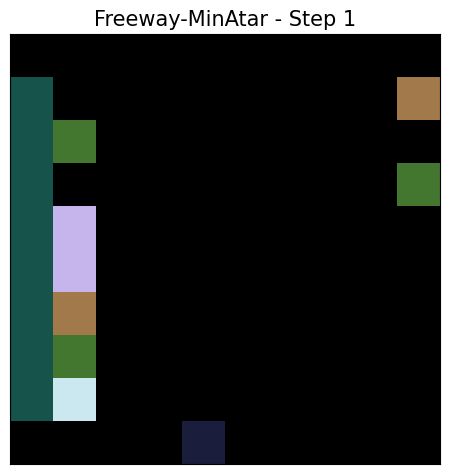

In [44]:
import gymnax
from gymnax.visualize import Visualizer

key = jax.random.PRNGKey(42)
key_reset, key_act, key_step, key = jax.random.split(key, 4)

# Instantiate the environment & its settings.
env, env_params = gymnax.make("Freeway-MinAtar")

# Reset the environment.
obs, state = env.reset(key_reset, env_params)

# Sample a random action.
action = env.action_space(env_params).sample(key_act)

# Perform the step transition.
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)

vis = Visualizer(env, env_params, [state])
vis.init()
vis.update(0)

正直このVisualizerのAPIはどうなんだろう？という気もしますが...きちんとFour Roomsを表示してくれました。

# DQNを試してみる
とりあえずPPOをやってみます。

In [39]:
env.action_space(env_params).n

3

In [40]:
env.observation_space(env_params).high

1